In [1]:
import numpy as np
from datetime import datetime, timedelta
import glob
import mne
import re
import pandas as pd 
import matplotlib.pyplot as plt

from pathlib import Path
import warnings
warnings.filterwarnings('ignore') #living on the edge (but i really hate warnings)

In [2]:
#Gather all resting state recordings
#this takes a while due to some 10khz recordings
BASE_PATH = '/mnt/sinuhe/data_raw/**/**/**/*.fif'

files = glob.glob(BASE_PATH)
files = [file for file in files if 'rest' in file or 'Rest' in file or 'REST' in file]

subject_ids = []
measurement_age = []
measurement_date = []
measurement_age_days = []
clean_path = []
fs_1k = []

for file in files:
    f_split = file.split('/')
    cur_id = f_split[-1].lower()[:12]
        
    if re.match("\d{8}[a-z]{4}", cur_id) and 'sss' not in f_split[-1]: #only take proper ids for now

        cur_data = mne.io.read_raw_fif(file, verbose=False, allow_maxshield=True)
        if cur_data.info['sfreq'] == 1000: #only take 1kHz recordings for now
            fs_1k.append(True)
        else:
            fs_1k.append(False)
        subject_ids.append(cur_id)
        recording_date = datetime.strptime(f_split[-2], '%y%m%d')
        try:
            birth_date = datetime.strptime(f_split[-1][:8], '%Y%m%d') #in ~2 cases dates are formatted weird
        except ValueError:
            pass
        
        measurement_age.append((recording_date - birth_date) // timedelta(days=365.2425))
        measurement_age_days.append((recording_date - birth_date).days)
        measurement_date.append(recording_date)
        clean_path.append(file)
        
        
df = pd.DataFrame({'subject_id': np.array(subject_ids),
                   'measurement_age': np.array(measurement_age),
                   'measurement_age_days': np.array(measurement_age_days),
                   'measurement_date': np.array(measurement_date),
                   'path': np.array(clean_path),
                   'fs_1k': np.array(fs_1k)})

df = df[df['measurement_age'] < 100] #remove methusalem
df

,subject_id,measurement_age,measurement_age_days,measurement_date,path,fs_1k
1,19800616mrgu,36,13429,2017-03-23,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
2,19851130eifi,31,11436,2017-03-23,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
3,19901026krke,26,9646,2017-03-24,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
4,19950604llzm,21,7964,2017-03-24,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
5,19961118brsh,20,7431,2017-03-24,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
...,...,...,...,...,...,...
2322,19600904efsh,63,23020,2023-09-14,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True
2323,19600820crse,63,23040,2023-09-19,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True
2324,19661221efkc,56,20726,2023-09-19,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True
2325,19560524uske,67,24591,2023-09-21,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True


In [3]:
df.to_csv('./resting_list.csv')

In [4]:
# do some additional subselection
df = pd.read_csv('./resting_list.csv')

df['experiment'] = [cur_subject[1]['path'].split('/')[4] for cur_subject in df.iterrows()]

bad_resting_recording = ['gr_cocktail_effort']

df_good = df.query('experiment != @bad_resting_recording')


open_eyes = [False if 'closed' in cur_subject[1]['path'].split('/')[-1] else True for cur_subject in df_good.iterrows()]
df_good = df_good[open_eyes]

In [5]:
df_good

,Unnamed: 0,subject_id,measurement_age,measurement_age_days,measurement_date,path,fs_1k,experiment
0,1,19800616mrgu,36,13429,2017-03-23,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
1,2,19851130eifi,31,11436,2017-03-23,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
2,3,19901026krke,26,9646,2017-03-24,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
3,4,19950604llzm,21,7964,2017-03-24,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
4,5,19961118brsh,20,7431,2017-03-24,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
...,...,...,...,...,...,...,...,...
2321,2322,19600904efsh,63,23020,2023-09-14,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True,th_donottrackmycocktaileye
2322,2323,19600820crse,63,23040,2023-09-19,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True,th_donottrackmycocktaileye
2323,2324,19661221efkc,56,20726,2023-09-19,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True,th_donottrackmycocktaileye
2324,2325,19560524uske,67,24591,2023-09-21,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True,th_donottrackmycocktaileye


In [6]:
df_unique = df_good.drop_duplicates(subset='subject_id', keep='last')
df_unique.to_csv('./resting_list_single.csv')

In [7]:
df_unique

,Unnamed: 0,subject_id,measurement_age,measurement_age_days,measurement_date,path,fs_1k,experiment
2,3,19901026krke,26,9646,2017-03-24,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
5,6,19700131cris,47,17244,2017-04-18,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
6,7,19620826wlti,54,19976,2017-05-05,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
8,9,19950326iiqi,22,8076,2017-05-05,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
15,16,19631206crri,53,19677,2017-10-20,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
...,...,...,...,...,...,...,...,...
2321,2322,19600904efsh,63,23020,2023-09-14,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True,th_donottrackmycocktaileye
2322,2323,19600820crse,63,23040,2023-09-19,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True,th_donottrackmycocktaileye
2323,2324,19661221efkc,56,20726,2023-09-19,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True,th_donottrackmycocktaileye
2324,2325,19560524uske,67,24591,2023-09-21,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True,th_donottrackmycocktaileye


In [19]:
#... seems like everything was actually fine resting always in the beginning
problematic_resting = ['gd_markov']

good_subjects, bad_subjects = [], []

df_prob = df_good.query('experiment == "gd_markov"').copy()

for cur_date in df_prob['measurement_date'].unique():

    cur_date_df = df_prob.query(f'measurement_date == "{cur_date}"')

    for subject in cur_date_df['subject_id'].unique():

       cur_sub_df = cur_date_df.query(f'subject_id == "{subject}"')

       
       #print(cur_sub_df['path'].iloc[0])
       try:
           raw_exp = mne.io.read_raw_fif(list(Path('/').glob(cur_sub_df['path'].iloc[0][1:66] + '*block*.fif'))[0], verbose=False, allow_maxshield=True)
           raw_rest = mne.io.read_raw_fif(cur_sub_df['path'].iloc[0], verbose=False, allow_maxshield=True) #assuming there was only one resting state per day

           diff_min = (raw_exp.info['meas_date'] - raw_rest.info['meas_date']).seconds / 60
           print(f'There was a difference of {diff_min} between the recordings')

           raw_rest.info['meas_date'] - raw_exp.info['meas_date']
           if raw_rest.info['meas_date'] < raw_exp.info['meas_date']:
               good_subjects.append(cur_sub_df)
           else:
               bad_subjects.append(cur_sub_df)

       except IndexError:
           good_subjects.append(cur_sub_df)

There was a difference of 5.766666666666667 between the recordings
There was a difference of 5.933333333333334 between the recordings
There was a difference of 6.366666666666666 between the recordings
There was a difference of 5.75 between the recordings
There was a difference of 6.7 between the recordings
There was a difference of 6.3 between the recordings
There was a difference of 6.416666666666667 between the recordings
There was a difference of 6.233333333333333 between the recordings
There was a difference of 6.35 between the recordings
There was a difference of 5.833333333333333 between the recordings
There was a difference of 2.716666666666667 between the recordings
There was a difference of 4.466666666666667 between the recordings
There was a difference of 3.3333333333333335 between the recordings
There was a difference of 7.25 between the recordings
There was a difference of 3.683333333333333 between the recordings
There was a difference of 3.783333333333333 between the recor

KeyboardInterrupt: 

In [20]:
df_good_2 = pd.concat(good_subjects)

In [9]:
#TODO: Drop bad studies before dropping duplicate subjects -> no bad studies detected
df_unique = df.drop_duplicates(subset='subject_id', keep='last')
df_unique.to_csv('./resting_list_single.csv')

In [21]:
df_unique

,Unnamed: 0,subject_id,measurement_age,measurement_age_days,measurement_date,path,fs_1k,experiment
2,3,19901026krke,26,9646,2017-03-24,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
5,6,19700131cris,47,17244,2017-04-18,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
6,7,19620826wlti,54,19976,2017-05-05,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
8,9,19950326iiqi,22,8076,2017-05-05,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
15,16,19631206crri,53,19677,2017-10-20,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
...,...,...,...,...,...,...,...,...
2321,2322,19600904efsh,63,23020,2023-09-14,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True,th_donottrackmycocktaileye
2322,2323,19600820crse,63,23040,2023-09-19,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True,th_donottrackmycocktaileye
2323,2324,19661221efkc,56,20726,2023-09-19,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True,th_donottrackmycocktaileye
2324,2325,19560524uske,67,24591,2023-09-21,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True,th_donottrackmycocktaileye


(array([943., 728., 172.,  92.,  39., 111., 190.,  42.,   8.,   1.]),
 array([18. , 24.8, 31.6, 38.4, 45.2, 52. , 58.8, 65.6, 72.4, 79.2, 86. ]),
 <BarContainer object of 10 artists>)

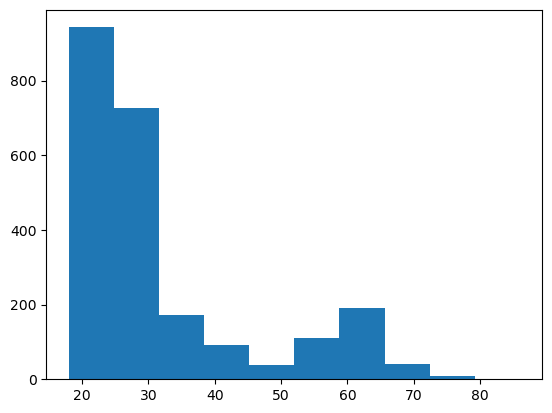

In [22]:
plt.hist(df['measurement_age'])

In [11]:
#Get subject ids with multiple recordings
df_1k = df[df['fs_1k']]
ids, counts = np.unique(df_1k['subject_id'], return_counts=True)
id_list = ids[counts > 4]

df_multi = df_1k.query('subject_id in @id_list')
df_multi.reset_index(inplace=True)
df_multi.drop(columns='index', inplace=True)
df_multi.to_csv('./resting_list_multi.csv')

df_multi

,Unnamed: 0,subject_id,measurement_age,measurement_age_days,measurement_date,path,fs_1k,experiment
0,1,19800616mrgu,36,13429,2017-03-23,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
1,10,19810726gdzn,35,13141,2017-07-18,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
2,36,19870319wlgl,31,11390,2018-05-25,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
3,48,19800616mrgu,38,13987,2018-10-02,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
4,49,19940430slbc,24,8921,2018-10-02,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True,gd_markov
...,...,...,...,...,...,...,...,...
591,2286,19910823ssld,31,11625,2023-06-21,/mnt/sinuhe/data_raw/aw_ncc/subject_subject/23...,True,aw_ncc
592,2287,19971028mrhs,25,9367,2023-06-21,/mnt/sinuhe/data_raw/aw_ncc/subject_subject/23...,True,aw_ncc
593,2288,19800616mrgu,43,15717,2023-06-28,/mnt/sinuhe/data_raw/aw_ncc/subject_subject/23...,True,aw_ncc
594,2292,19990227caks,24,8831,2023-05-03,/mnt/sinuhe/data_raw/th_donottrackmycocktailey...,True,th_donottrackmycocktaileye


In [12]:
rep_ids = ids[counts > 4]
reps = counts[counts > 4]

In [13]:
reps#

array([10, 11, 10,  5, 33,  6,  6, 17,  5,  5,  8, 10,  5, 16, 10, 19, 31,
        6,  8, 11, 10, 13, 13,  5, 14,  9,  6,  5, 11, 11, 15, 10,  8,  6,
       11, 10, 11,  9, 26, 10,  5,  5,  5, 11, 14, 12, 28, 10, 10,  5,  5,
       11, 10, 10, 10])

In [14]:
age_dist = []

for subject in rep_ids:
    cur_df = df_multi.query(f'subject_id == "{subject}"')
    age_dist.append(cur_df['measurement_age'].max() - cur_df['measurement_age'].min())

rep_ids[np.array(age_dist) > 0]

array(['19680529eidx', '19791024eetm', '19800616mrgu', '19800908igdb',
       '19810726gdzn', '19860620hrwc', '19861026crzm', '19870319wlgl',
       '19880705lhko', '19890621rssh', '19891222gbhl', '19910612crke',
       '19910703eigl', '19910704hbea', '19910811sbsu', '19910823ssld',
       '19920208dnkp', '19921204rtse', '19930118imsh', '19930506urhe',
       '19930630mnsu', '19930819crbo', '19940430slbc', '19940930nkbh',
       '19950913gbwl', '19951227eipo', '19960122urfo', '19960411mnfl',
       '19960418gbsh', '19960630cahi', '19961106sbgi', '19961110brpl',
       '19961112cahn', '19970203urmr', '19971028mrhs', '19990227caks',
       '19990303hlas'], dtype=object)

(array([18.,  5.,  9.,  0.,  6.,  8.,  0.,  8.,  0.,  1.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

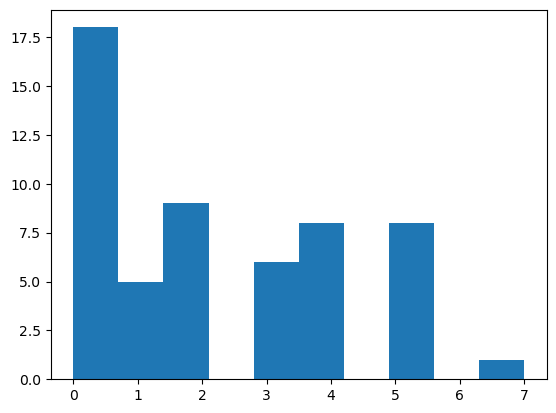

In [15]:
plt.hist(age_dist)

In [18]:
rep_ids[np.array(age_dist) > 0].shape

(37,)

<BarContainer object of 55 artists>

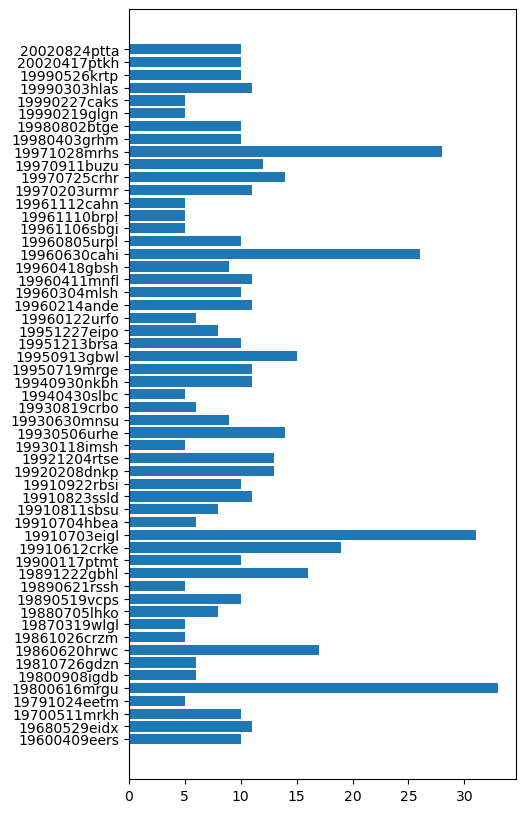

In [17]:
plt.figure(figsize=(5,10))
plt.barh(y=rep_ids, width=reps)